* American Gut Project
* License: BSD
* Author of this notebook: Daniel McDonald

For this notebook, we're going to explore how the number of shared OTUs differs based on metadata. What these plots will show are the number of OTUs that are shared in an increasing number of samples. For instance, we expect to see a very large number of OTUs shared in at least 1% of the samples, fewer that are shared in at least 10%, even fewer at 50%, and almost none in 100% of the samples. This makes sense as we harbor unique microbial communities.

This Notebook assumes the following dependencies are in your environment:

* [BIOM](http://biom-format.org) >= 2.1.0
* [matplotlib](http://matplotlib.org/) >= 1.1.0


In [17]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from biom import load_table
from biom.parse import MetadataMap
from collections import Counter

In [3]:
!curl -OL https://github.com/biocore/American-Gut/raw/master/data/AG/AG_100nt_even10k.txt
!curl -OL https://github.com/biocore/American-Gut/raw/master/data/AG/AG_100nt_even10k.biom

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   156    0   156    0     0    269      0 --:--:-- --:--:-- --:--:--   269
100 5638k  100 5638k    0     0  2209k      0  0:00:02  0:00:02 --:--:-- 3029k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   157    0   157    0     0    289      0 --:--:-- --:--:-- --:--:--   289
100 11.1M  100 11.1M    0     0  1715k      0  0:00:06  0:00:06 --:--:-- 1507k


In [4]:
metadata = MetadataMap.from_file('AG_100nt_even10k.txt')
table = load_table('AG_100nt_even10k.biom')
table.add_metadata(metadata)

The first function that we're going to define will compute the percentage of shared OTUs over the samples for a specific metadata category and value.

In [5]:
def compute_shared_otus(table_full, category, values):
    """Compute shared OTUs for a given category and values
    
    Parameters
    ----------
    table_full : Table
        A BIOM table. It is assumed that this table has sample metadata associated with it.
    category : str
        The metadata category
    values : list of str
        The values of interest within the category
    
    Returns
    -------
    np.array
        Observed percentages
    np.array
        Observed top OTU IDs
    list
        Observed top taxa
    int
        Number of samples in the filtered table
    
    """
    def _get_taxa(t, id_):
        md = t.metadata(id_, axis='observation')
        if md is None:
            taxa = ''
        else:
            taxa = '; '.join(md['taxonomy'])
        return taxa
    
    table = table_full.pa(inplace=False)
    
    # filter to just those samples that meet our metadata category and values
    cat_fn = lambda v, i, md: md[category] in values
    site = table.filter(cat_fn, inplace=False)

    # normalize
    norm_fn = lambda v, i, md: v / len(site.ids(axis='sample'))
    site.transform(norm_fn)
    
    # compute percents
    obs_full = site.sum('observation')
    obs_percents = np.array([(obs_full > i).sum() for i in np.arange(0.0, 1.0, 0.01)], dtype=float)
    
    # determine the taxa that appear to be highly shared
    top_ids = site.ids(axis='observation')[np.argwhere(obs_full > 0.95)].squeeze()
    top_taxa = []
    if len(np.atleast_1d(top_ids)) > 0:
        if not top_ids.shape: # array of scalar value
            top_ids = np.array(str(top_ids))
            top_taxa.append(_get_taxa(site, str(top_ids)))
        else:
            for id_ in top_ids:
                top_taxa.append(_get_taxa(site, id_))
    
    return obs_percents, top_ids, top_taxa, len(site.ids(axis='sample'))

In the next cell, we're going to first define a helper function for filtering to just fecal samples, and then define a more complex method that will allow us to compute shared OTUs over multiple category values within a metadata category. This method will additionally subsample the number of samples being examined to normalize for the number of samples used in the compute within each category value. Since we're subsampling the category values that have a larger number of samples associated, we're going to perform the subsample multiple times and return the mean shared OTUs observed. 

In [6]:
fecal_filter = lambda v, i, md: md['BODY_SITE'] == 'UBERON:feces'
def compute_multiple_values(table_full, category, min_count=25, prefilter=fecal_filter, iterations=10, 
                            discretize=None):
    """Compute shared OTUs over multiple category values
    
    This method will print summary details about the category being examined which can
    be used to inform a good min_count.
        
    Parameters
    ----------
    table_full : Table
        The full table to operate on.
    category : str
        The metadata category to examine.
    min_count : int, optional
        The minimum number of samples that must be associated with a category value.
        Defaults to 25.
    prefilter : func
        Prefilter, e.g., down to just fecal samples
    iterations : int, optional
        Number of rarefactions to perform
    discretize : list of tuple, optional
        Bins to discretize the data. Expected form: [(min, max)]
        
    Returns
    -------
    np.array
        The mean observed percents in row order with observed values
    np.array
        The stderr observed percents in row order with observed values
    list of str
        The observed category values
    int
        Sample depth used
        
    Notes
    -----
    This method ignores NA and no_data category values
    
    """
    def make_filter_f(md_field, md_val):
        """Construct a filter function based on a metadata category and value
        
        If md_val is a tuple, a discretization is attempted.
        """
        if isinstance(md_val, tuple):
            min_, max_ = md_val
            def f(v, i, samp_md):
                """Return True if the sample is value is min_ <= foo < max_"""
                try:
                    return min_ <= float(samp_md[md_field]) < max_
                except ValueError:
                    return False
        else:
            def f(v, i, samp_md):
                """Return true if the sample is associated with our desired value"""
                return samp_md[md_field] == md_val
        return f
    
    pa = table_full.filter(prefilter, inplace=False).pa()
    
    # get the counts within each category value
    metadata_counts = Counter()
    for md in pa.metadata(axis='sample'):
        # ignore missing data
        if md[category] in ['NA', 'no_data', '']:
            continue
            
        if discretize is not None:
            for min_, max_ in discretize:
                if min_ <= float(md[category]) < max_:
                    metadata_counts[(min_, max_)] += 1
                    break
        else:
            metadata_counts[md[category]] += 1
    
    metadata_counts = {k: v for k, v in metadata_counts.items() if v > 1}
        
    print "Category counts for %s:" % category
    for k, v in sorted(metadata_counts.items(), key=lambda item: item[1], reverse=True):
        print "  %s: %d" % (k, v)
        
    # determine the minimum sampling depth
    sample_depth = min(filter(lambda v: v > min_count, metadata_counts.values()))        
    metadata_values = [k for k, v in metadata_counts.items() if v >= sample_depth]
    
    observed_means = []
    observed_stderrs = []
    observed_values = []
    for obs_v in sorted(metadata_values):
        if discretize is not None:
            observed_values.append("%d <= x < %d" % obs_v)
        else:
            observed_values.append(obs_v)
    
        # filter to the specific category value
        md_specific = pa.filter(make_filter_f(category, obs_v), inplace=False)
        ids = md_specific.ids(axis='sample').copy() 

        results = np.zeros((iterations, 100), dtype=float)
        for idx in range(iterations):
            # subsample the table
            np.random.shuffle(ids)
            subsampled_ids = set(ids[:sample_depth])
            filter_f = lambda v, i, md: i in subsampled_ids
            ss = md_specific.filter(filter_f, inplace=False)
            ss.filter(lambda v, i, md: sum(v) > 0, axis='observation')

            # normalize
            norm_f = lambda v, i, md: v / len(ss.ids(axis='sample'))
            ss.transform(norm_f)
            
            # compute percents
            obs_full = ss.sum('observation')
            results[idx] = np.array([(obs_full > j).sum() for j in np.arange(0.0, 1.0, 0.01)], dtype=float)        
        
        observed_means.append(results.mean(axis=0))
        observed_stderrs.append(results.std(axis=0) / np.sqrt(iterations))
    
    return np.asarray(observed_means), np.asarray(observed_stderrs), observed_values, sample_depth

Finally, we're going to construct a method to plot the results of out shared OTUs functions.

In [28]:
def plot_shared_otus(n_samples, percents, labels, title=None, depth=None, stderrs=None, start=0):
    """Plot the shared OTUs
    
    Parameters
    ----------
    n_samples : int
        The number of samples reflected
    percents : np.array
        The percents to plot
    title : str, optional
        Additional title name
    depth : int, optional
        The subsample depth
    """ 
    if len(percents.shape) == 1:
        percents = np.array([percents])
    
    fig = plt.figure()
    ax_count = plt.gca()
    
    title_str = 'Shared OTUs'
    
    if title is not None:
        title_str += ': %s' % title
    if depth is not None:
        title_str += ', n=%d' % depth
    
    ax_count.set_title(title_str)
    ax_count.set_yscale('log')
    ax_count.set_ylabel('Number of OTUs')
    ax_count.set_xlabel('Number of samples')
    
    x_ticks = np.arange(0.0, 1.0, 0.01) * n_samples
    
    for idx, row in enumerate(percents):
        if stderrs is not None:
            ax_count.errorbar(x_ticks[start:], row[start:], yerr=stderrs[idx][start:], fmt='o', 
                              markersize=5, markeredgewidth=0.25)
        else:
            ax_count.plot(x_ticks[start:], row[start:])

    plt.legend(labels, numpoints=1)
            
    plt.tight_layout()
    ax_count.grid()
    
    return fig

Next, we're going to define a few helper methods just to make the subsequent calls very easy. The compute methods above return other interesting bits of information though which you may like to explore.

In [29]:
def helper_single(category, values, label):
    percents, top_ids, top_taxa, n_samples = compute_shared_otus(table, category, values)
    plot_shared_otus(n_samples, percents, [label])
    print "Top observed shared taxa:"
    for t in top_taxa:
        print '    %s' % t

def helper_multiple(category, title, min_count=None, discretize=None):
    means, stderrs, values, depth = compute_multiple_values(table, category, min_count, discretize=discretize)
    fig = plot_shared_otus(depth, means, values, title=title, depth=depth)
    return fig

**Plots**

Now lets go and make some plots using the functions we just created. The first three plots will be high level, and just of the body sites. What you can see is that there are a lot of shared OTUs between people, but the number that are shared begin to drop off quickly as you increase the number of samples (_note that the y-axis is in a log-scale_). It does appear that a handful of OTUs are shared over all samples within the oral and skin sites but the over all sample size is much lower than the fecal site.

Top observed shared taxa:
    k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__
    k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__
    k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__
    k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Coprococcus; s__
    k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__
    k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia; s__
    k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Faecalibacterium; s__prausnitzii
    k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__


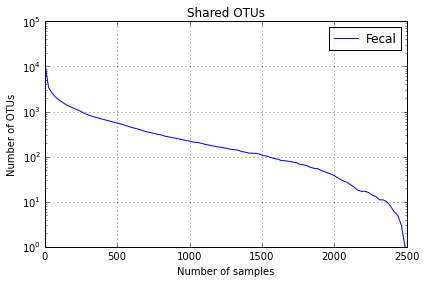

In [9]:
helper_single('BODY_SITE', ['UBERON:feces'], 'Fecal')

Top observed shared taxa:
    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Corynebacteriaceae; g__Corynebacterium; s__
    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas; s__
    k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__aureus
    k__Bacteria; p__Cyanobacteria; c__Chloroplast; o__Streptophyta; f__; g__; s__
    k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__
    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pasteurellales; f__Pasteurellaceae; g__Haemophilus; s__parainfluenzae
    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Propionibacteriaceae; g__Propionibacterium; s__acnes
    k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Corynebacteriaceae; g__Corynebacterium; s__
    k__Bacteria; p__Proteobacteria; c__Gammapr

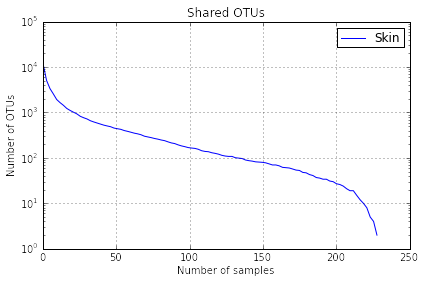

In [10]:
helper_single('BODY_SITE', ['UBERON:skin', 'UBERON:hand'], 'Skin')

Top observed shared taxa:
    k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pasteurellales; f__Pasteurellaceae; g__Haemophilus; s__parainfluenzae
    k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Carnobacteriaceae; g__Granulicatella; s__
    k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__
    k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__


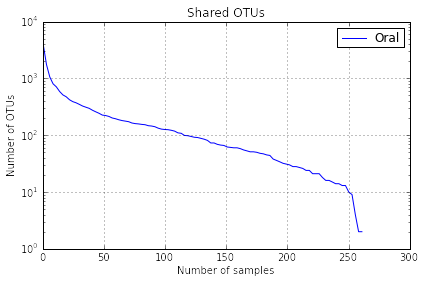

In [11]:
helper_single('BODY_SITE', ['UBERON:tongue'], 'Oral')

Now, lets slice and dice the data further. The next set of plots will look just within the fecal samples, and then within a given metadata category. Since we have uneven numbers of samples associated with each category (e.g., the number of people who have taken antibiotics recently is much less than the number of people who have not taken antibiotics in the last year), we're going to randomly select an even number of samples within each group and then compute shared OTUs from there. Since we're randomly subsampling, we're going to do this procedure 10 times and plot the mean number of shared OTUs.

In the first plot, we're taking a look at the number of shared OTUs stratified by how recently antibiotics were used.  

Category counts for ANTIBIOTIC_SELECT:
  Not in the last year: 1672
  In the past year: 323
  In the past 6 months: 289
  In the past month: 73
  In the past week: 50


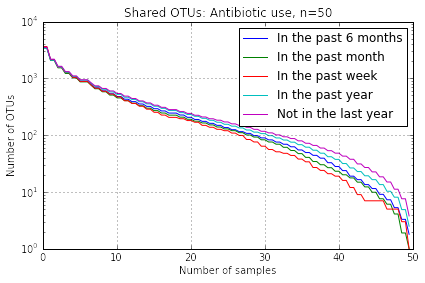

In [12]:
helper_multiple('ANTIBIOTIC_SELECT', 'Antibiotic use')

In the next plot, we're looking at whether seasonal allergies appear to impact the number of shared OTUs. 

Category counts for SEASONAL_ALLERGIES:
  no: 1395
  yes: 958


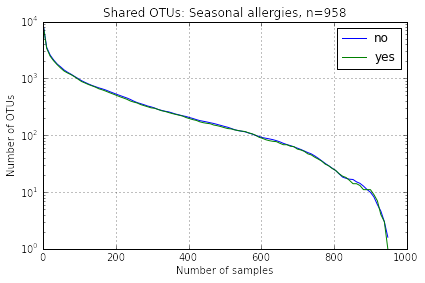

In [13]:
helper_multiple('SEASONAL_ALLERGIES', 'Seasonal allergies')

Diet interestingly appears to show a difference, with vegans having the most shared OTUs. This could potentially be explained by the number of plants consumed (see below), which appear to be associated with the number of shared OTUs.

Category counts for DIET_TYPE:
  Omnivore: 1983
  Omnivore but no red meat: 154
  Vegetarian but eat seafood: 149
  Vegetarian: 85
  Vegan: 47


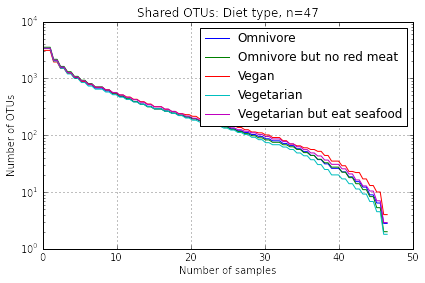

In [14]:
helper_multiple('DIET_TYPE', 'Diet type')

The number of plants consumed in a given week looks like it may have an affect as well, where if you consume less than 5 different types of plants per week, you appear to have fewer shared OTUs with the rest of the population.

Category counts for TYPES_OF_PLANTS:
  11 to 20: 747
  6 to 10: 568
  21 to 30: 459
  More than 30: 365
  Less than 5: 194
  unknown: 87


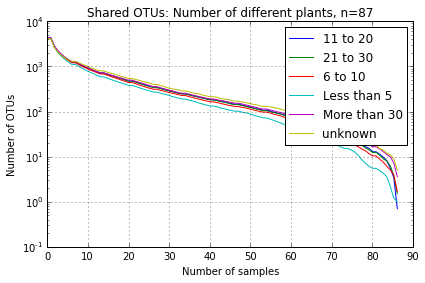

In [30]:
fig = helper_multiple('TYPES_OF_PLANTS', 'Number of different plants')

In [32]:
fig.savefig('/Users/jwdebelius/Desktop/plants_figure/shared_otus.pdf')

Now lets take a look at BMI. Interestingly, both the severely underweight and severely obese groups show a reduced number of shared OTUs.

Category counts for BMI:
  (18, 25): 1390
  (25, 30): 471
  (30, 35): 134
  (0, 18): 131
  (35, 40): 40


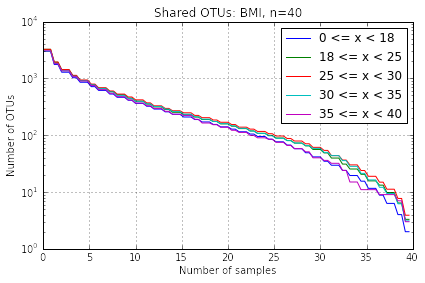

In [16]:
BMI_ranges = [(0, 18),
              (18, 25),
              (25, 30),
              (30, 35),
              (35, 40)]
helper_multiple('BMI', 'BMI', discretize=BMI_ranges)